In [1]:
import os
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras_preprocessing.image import ImageDataGenerator


###!NOTE using keras function flow_from_directory does not work because image are tif
#### however datagenerator seems to work... 


data_dir='Data/Dataset2-Durum Wheat Video Images'


#original full image size is about 890*1080 ; 
#wheat grain subimage are about 50*80
img_width=340
img_height=400 





In [2]:


subdir=os.listdir(data_dir)

#removed subdir with mixt stuff
for sub in list(subdir):
    if 'Mixture' in sub:
        subdir.remove(sub)

print(subdir)

Df=pd.DataFrame()
count=0
for i in range(len(subdir)):
    fpath =data_dir+'/'+subdir[i]
    for file in os.listdir(fpath):
        label=subdir[i].split(' ')[2]
        row=pd.DataFrame(data={"filename": fpath+'/'+file, "class": label},index=[count])
        Df=pd.concat([Df,row])

        count+=1


Df.head()


#####label encoding not needed with imageDatagenerator
#y_encoder=LabelEncoder()
#y=y_encoder.fit_transform(Df['class'])
#Df['class']=y


#cut dataframe into train, eval and test 
Df_train,Df_nottrain=train_test_split(Df,test_size=0.2) # (1-test_size)*100=80% for training
Df_eval,Df_test=train_test_split(Df_nottrain,test_size=0.7)



print(Df_train.shape)
print(Df_eval.shape)
print(Df_test.shape)

Df_eval

['1-Images from Vitreous Durum Wheat', '2-Images from Starchy Durum Wheat', '3-Images from Foreign Matters']
(156, 2)
(11, 2)
(28, 2)


,filename,class
10,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous
93,Data/Dataset2-Durum Wheat Video Images/2-Image...,Starchy
88,Data/Dataset2-Durum Wheat Video Images/2-Image...,Starchy
30,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous
163,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign
106,Data/Dataset2-Durum Wheat Video Images/2-Image...,Starchy
176,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign
187,Data/Dataset2-Durum Wheat Video Images/3-Image...,Foreign
18,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous
35,Data/Dataset2-Durum Wheat Video Images/1-Image...,Vitreous


In [3]:
# note categorical class mode would be ok with onehot encoded label. here use 'sparse', ie. discrete values

### see https://j-l-m.github.io/Keras_using_pretrained_VGG16/

datagen=ImageDataGenerator(rescale=1/255)
train_datagen=datagen.flow_from_dataframe(dataframe=Df_train,
                                          target_size=(img_width,img_height),
                                          class_mode='sparse', 
                                          shuffle=True # so order in filename is not important
                                          )

#datagen=ImageDataGenerator(rescale=1/255)
eval_datagen=datagen.flow_from_dataframe(dataframe=Df_eval,
                                          target_size=(img_width,img_height),
                                          class_mode='sparse',
                                          shuffle=True # so order in filename is not important
                                          )


test_datagen=datagen.flow_from_dataframe(dataframe=Df_test,
                                          target_size=(img_width,img_height),
                                          class_mode='sparse',
                                          shuffle=True # so order in filename is not important
                                          )





                                        

Found 156 validated image filenames belonging to 3 classes.
Found 11 validated image filenames belonging to 3 classes.
Found 28 validated image filenames belonging to 3 classes.


In [4]:
train_datagen.class_indices #ok!!!

{'Foreign': 0, 'Starchy': 1, 'Vitreous': 2}

In [5]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
#from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
import keras
from tensorflow.keras.backend import clear_session


Vgg_model=VGG16(weights='imagenet',
                input_shape=(img_width,img_height,3),
                include_top=False,  # include_top=True mean image size fixed to 224*244*3
                pooling='max'
                )


Res_model=ResNet50(weights='imagenet',
                   input_shape=(img_width,img_height,3),
                   include_top=False,  # include_top=True mean image size fixed to 224*244*3
                   pooling='max'
                   )

#https://keras.io/api/applications/vgg/




clear_session() #clear keras session


def build_model(Pre_model):
    'build model from a pretrained model'
    model=Sequential()
    for layer in Pre_model.layers:
        layer.trainable=False #freeze the layer coming from Pretrained model
        model.add(layer)

    model.add(Flatten()) #reshape in 1D
    #model.add(Dropout(0.2))
    model.add(Dense(units=1024,activation='relu'))
    model.add(Dense(units=3,activation='softmax'))



    opt = Adam(learning_rate=0.0005)
    model.compile(  optimizer=opt,
                    loss=keras.losses.sparse_categorical_crossentropy,
                    metrics=['accuracy']
                    )

    return model



vgg_derived=build_model(Vgg_model)
#resnet_derived=build_model(Res_model) some bug here, ' Input 0 of layer "conv2_block1_3_conv" is incompatible with the layer: expected axis -1 '
#!!!!resnet to try!!!

c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.5398 - loss: 0.9693 - val_accuracy: 0.6364 - val_loss: 0.5014
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7973 - loss: 0.4107 - val_accuracy: 1.0000 - val_loss: 0.2629
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 1.0000 - loss: 0.2053 - val_accuracy: 1.0000 - val_loss: 0.1729
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 1.0000 - loss: 0.1217 - val_accuracy: 1.0000 - val_loss: 0.1143
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 1.0000 - loss: 0.0888 - val_accuracy: 1.0000 - val_loss: 0.0802
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 1.0000 - loss: 0.0611 - val_accuracy: 1.0000 - val_loss: 0.0530
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 1.0000 - loss: 0.0451 - val_accuracy: 1.0000 - val_loss: 0.0393
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 1.0000 - loss: 0.0333 - val_accuracy: 1.0000 - val_loss: 0.0332
Epoch 9/

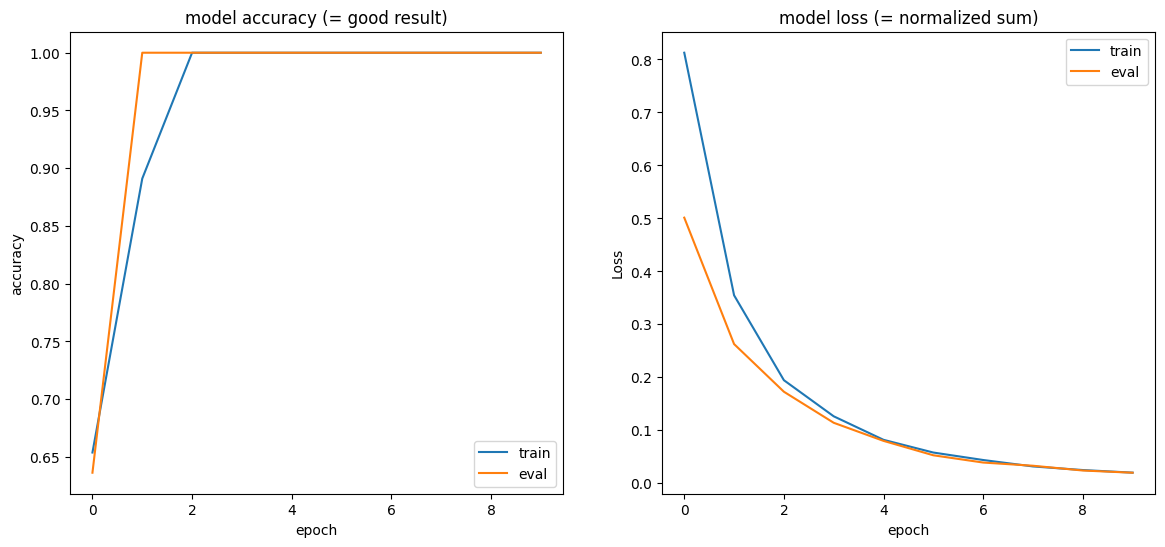

In [6]:
import matplotlib.pyplot as plt


model=vgg_derived

history = model.fit(train_datagen,
                    validation_data=eval_datagen,
                    epochs=10
                    ) 


fig,ax=plt.subplots(1,2,figsize=(14,6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy (= good result)')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'eval'])


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss (= normalized sum)')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'eval'])


c:\Users\juano\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[0, 2, 2, 0, 2, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 2, 1, 2, 2, 0, 1, 1, 2, 0, 1, 1, 0, 0]
[0 2 2 0 2 0 0 0 1 2 0 1 2 0 1 2 1 2 2 0 1 1 2 0 1 1 0 0]
   -----> Vgg_derived <-----   


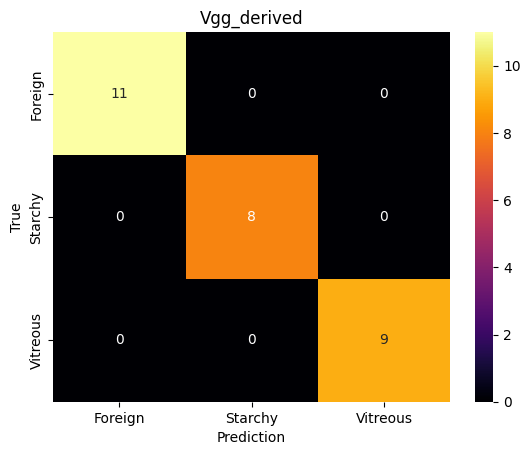

accuracy=100.00
              precision    recall  f1-score   support

     Foreign       1.00      1.00      1.00        11
     Starchy       1.00      1.00      1.00         8
    Vitreous       1.00      1.00      1.00         9

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28


 
 



In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns


def show_confusion(y_test,y_predic,classes,key):
    '''
    Show confusion matrix and classification error for a given prediction (= classification here)
    '''

    cm = confusion_matrix(y_test, y_predic)
    #fig,ax=plt.subplots(2,3,figsize)
    ax=sns.heatmap(cm,annot=True,cmap='inferno',fmt='g',xticklabels=classes,yticklabels=classes)
    ax.set(xlabel='Prediction',ylabel='True')
    ax.set(title=key)

    acc='{:.2f}'.format(accuracy_score(y_test,y_predic)*100 )  
    report=classification_report(y_test, y_predic,target_names=classes,output_dict=False)

    print('   -----> '+key+' <-----   ')
    plt.show()
    print('accuracy='+acc)
    print(report)
    print('\n \n \n')




# get a prediction on ensemble NOT used for fine tuning the model and where truth i known
Data=test_datagen
Data.shuffle=False # if true, data will be re shuffled another time,leading to a bunch of false results
true_class=Data.classes

# get model classify label_index in label_name alphabetic order
convert_dic=train_datagen.class_indices
convert_dic_inv= {v:k for k,v in convert_dic.items()}

# make a prediction
y_proba=model.predict(Data) #... there are label in test filename but not in the images themself
y_pred=np.argmax(y_proba,axis=1) 

y_pred_name=[]
for i in y_pred:
    y_pred_name.append(convert_dic_inv[i])

y_test_name=[]
for i in true_class:
    y_test_name.append(convert_dic_inv[i])

classes=list(convert_dic.keys())


print(Data.classes)
print(y_pred)

show_confusion(y_test_name,y_pred_name,classes,'Vgg_derived')


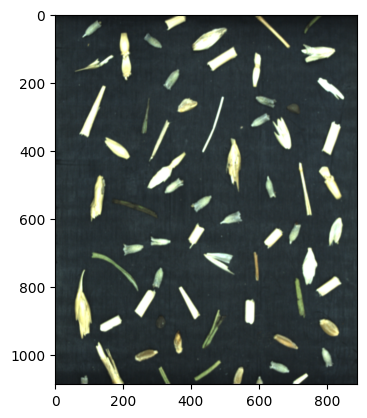

In [8]:
###### all images are correctly classified, but images contains a lot of wheat seed
import keras.utils as utils


filename=Df_test.iloc[0].filename
img=utils.load_img(filename)
img_array=utils.img_to_array(img)
img_array=img_array.astype(int)
plt.imshow(img_array)

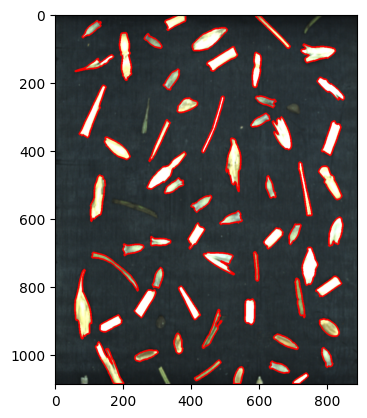

In [9]:
import cv2

# read image

# convert to grayscale
#convert image to 8bits, needed to gray conversion
img_array_8b=cv2.convertScaleAbs(img_array)
img_gray = cv2.cvtColor(img_array_8b,cv2.COLOR_RGB2GRAY)


# threshold
ret,thresh = cv2.threshold(img_gray,80,255,cv2.THRESH_BINARY)

# get contours
result = img_array_8b.copy()
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

clean_contours=[]
for contour in contours:
    area=cv2.contourArea(contour)
    if area> 600: #number of pixel i think
        clean_contours.append(contour)
    
cv2.drawContours(result,clean_contours,-1,(255,0,0),3)
plt.imshow(result)


In [ ]:
from tensorflow.keras.ops.image import resize 


batch=np.empty(shape=(len(clean_contours),img_height,img_width,3))
i=0
for contour in clean_contours:
    #contour=clean_contours[11]
    x,y,w,h=cv2.boundingRect(contour)
    subimg=img_array[y:y+h, x:x+w,:]


    #model is build for specific sized images!
    resized=resize(subimg,
                size=(img_height,img_width),
                fill_value=0,
                data_format='channels_last',
                interpolation='bilinear'
                )
    resized=resized.numpy() # i dont want tensor

    batch[i,:,:,:]=resized
    i=i+1


#plt.imshow(subimg)

#print(resized)
#resized.dtype
#batch=np.expand_dims(resized,axis=0)#for test on 1 sub picture
y_proba=model.predict(batch) #... there are label in test filename but not in the images themself
#print(y_proba)
y_pred=np.argmax(y_proba,axis=1) 
y_pred



2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
img_label=filename.split(' ')[5]
print(img_label)

true_label=convert_dic[img_label]
true_index=np.zeros(len(clean_contours))+true_label


n_exact=np.sum(y_pred==true_index) #true positive
n_inexact=len(clean_contours)-n_exact  #false negative 
recall=n_exact/len(clean_contours)  # the fraction of relevant instances that were retrieved
print (recall)

# starchy is sometime seen 

Foreign
0.9830508474576272


Text(0.5, 1.0, 'Prediction seed per seed \n green=good prediction \n red=not good')

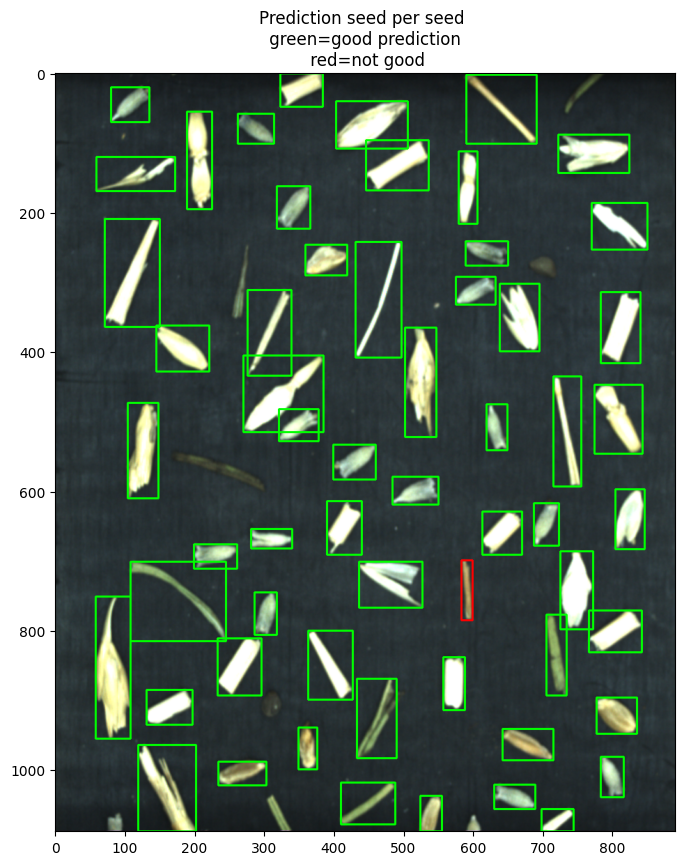

In [12]:

myimg=img_array_8b.copy()

for i in range(len(clean_contours)):
    contour=clean_contours[i]
    x,y,w,h=cv2.boundingRect(contour)
    if y_pred[i]==true_label:
#        cv2.drawContours(myimg,contour,-1,(0,255,0),3)
        cv2.rectangle(myimg,(x,y),(x+w,y+h),(0,255,0),2)

    else:
#        cv2.drawContours(myimg,contour,-1,(255,0,0),3)
        cv2.rectangle(myimg,(x,y),(x+w,y+h),(255,0,0),2) 


fig,ax=plt.subplots(figsize=(8,12))
ax.imshow(myimg)        
ax.set_title('Prediction seed per seed \n green=good prediction \n red=not good' )


#--> issues with seed sub images! because of resizing?